# Predicting number of COVID-19 cases per country

The goal is to predict current COVID-19 cases based on measures implemented by a country. 

### About the datasets

ACAPS COVID-19: Government Measures Dataset

The #COVID19 Government Measures Dataset is put togther by the Assessment Capacities Project [https://data.humdata.org/organization/acaps?sort=metadata_modified+desc]. It summarizes the measures implemented by governments worldwide in response to the Coronavirus pandemic according to five categories: social distancing, movement restrictions, public health measures, social and economic measures, and lockdowns. Each category is broken down into several types of measures. According to ACAPS, it has been created by consulting government, media, United Nations, and other organisations sources.  Some measures together with non-compliance policies may not be recorded and the exact date of implementation may not be accurate in some cases, due to the different way of reporting of the primary data sources we used. The dataset is updated weekly. Source: https://data.humdata.org/dataset/acaps-covid19-government-measures-dataset


The Global School Closures COVID-19 dataset includes information on closing of educational institutions by governments as a response to COVID-19. The dataset is based on information from UNESCO (https://en.unesco.org/themes/education-emergencies/coronavirus-school-closures). Source: https://data.humdata.org/dataset/global-school-closures-covid19

The time_series_covid19_confirmed_global dataset contains a summary of confirmed COVID-19 cases per country as reported by the John Hopkins University. It is updated daily. Source: https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv

## Import data

In [137]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline

## Load the data

#### COVID19 Government Measures Dataset

The COVID19 Government Measures Dataset contains information on implemented measures such as social distancing, movement restrictions, public health measures, social and economic measures, and lockdowns.

In [138]:
df_measures = pd.read_csv("data/acaps-covid-19-government-measures-dataset.csv", 
                         parse_dates=["date_implemented"]) # parsing dates

In [139]:
df_measures.columns

Index(['id', 'country', 'iso', 'admin_level_name', 'pcode', 'region',
       'category', 'measure', 'targeted_pop_group', 'comments',
       'non_compliance', 'date_implemented', 'source', 'source_type', 'link',
       'entry_date', 'alternative_source'],
      dtype='object')

First, we set up a dataframe with only features which are related to the implemented measures. 

In [140]:
df_measures = df_measures[["country", "category", "measure", "date_implemented"]]
df_measures.isna().sum()

country               0
category              0
measure               0
date_implemented    172
dtype: int64

In [141]:
df_measures.shape

(4149, 4)

In [142]:
df_measures = df_measures.rename(columns={"country": "Country/Region", "date_implemented": "date_measure_implemented"})
df_measures.head()

,Country/Region,category,measure,date_measure_implemented
0,Afghanistan,Public health measures,Health screenings in airports and border cross...,2020-02-12
1,Afghanistan,Public health measures,Introduction of quarantine policies,2020-02-12
2,Afghanistan,Public health measures,Awareness campaigns,2020-02-12
3,Afghanistan,Governance and socio-economic measures,Emergency administrative structures activated ...,2020-02-12
4,Afghanistan,Social distancing,Limit public gatherings,2020-03-12


In [143]:
# bring dataframe into wide format
df_measures = df_measures.pivot_table(index="Country/Region", 
                     columns=["category", "measure"], 
                     values="date_measure_implemented", 
                    aggfunc="first")

In [144]:
df_measures.head()

category            Governance and socio-economic measures  \
measure                                  Economic measures   
Country/Region                                               
Afghanistan                                            NaT   
Albania                                         2020-03-12   
Algeria                                                NaT   
Angola                                          2020-03-27   
Antigua and Barbuda                             2020-03-16   

category                                                                          \
measure             Emergency administrative structures activated or established   
Country/Region                                                                     
Afghanistan                                                 2020-02-12             
Albania                                                     2020-03-22             
Algeria                                                            NaT             
Angola                                                      2020-04-06             
Antigua and Barbuda                                         2020-03-16             

category                                                               \
measure             Limit product imports/exports Military deployment   
Country/Region                                                          
Afghanistan                            2020-03-01                 NaT   
Albania                                       NaT                 NaT   
Algeria                                       NaT          2020-03-23   
Angola                                 2020-03-27                 NaT   
Antigua and Barbuda                           NaT                 NaT   

category                                         Humanitarian exemption  \
measure             State of emergency declared Humanitarian exemptions   
Country/Region                                                            
Afghanistan                                 NaT                     NaT   
Albania                                     NaT                     NaT   
Algeria                                     NaT                     NaT   
Angola                               2020-03-27                     NaT   
Antigua and Barbuda                         NaT                     NaT   

category                 Lockdown  \
measure             Full lockdown   
Country/Region                      
Afghanistan                   NaT   
Albania                       NaT   
Algeria                       NaT   
Angola                        NaT   
Antigua and Barbuda           NaT   

category                                                               \
measure             Lockdown of refugee/idp camps or other minorities   
Country/Region                                                          
Afghanistan                                                       NaT   
Albania                                                           NaT   
Algeria                                                           NaT   
Angola                                                     2020-03-26   
Antigua and Barbuda                                               NaT   

category                              \
measure             Partial lockdown   
Country/Region                         
Afghanistan                      NaT   
Albania                   2020-04-02   
Algeria                   2020-03-23   
Angola                           NaT   
Antigua and Barbuda              NaT   

category                                            Movement restrictions  \
measure             Additional health/documents requirements upon arrival   
Country/Region                                                              
Afghanistan                                                        NaT      
Albania                                                            NaT      
Algeria                                                 

#### Number of confirmed COVID-19 cases

Then, we load the daily time series summary of confirmed COVID-19 cases.

In [145]:
df_confirmed_global = pd.read_csv("data/time_series_covid19_confirmed_global.csv")
df_confirmed_us = pd.read_csv("data/time_series_covid19_confirmed_US.csv")
df_confirmed_global.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,6/27/20,6/28/20,6/29/20,6/30/20,7/1/20,7/2/20,7/3/20,7/4/20,7/5/20,7/6/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,30616,30967,31238,31517,31836,32022,32324,32672,32951,33190
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,2330,2402,2466,2535,2580,2662,2752,2819,2893,2964
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,12968,13273,13571,13907,14272,14657,15070,15500,15941,16404
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,855,855,855,855,855,855,855,855,855,855
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,259,267,276,284,291,315,328,346,346,346


In [146]:
df_confirmed_global = df_confirmed_global[["Country/Region", "7/6/20"]]
df_confirmed_global.head()

,Country/Region,7/6/20
0,Afghanistan,33190
1,Albania,2964
2,Algeria,16404
3,Andorra,855
4,Angola,346


In [147]:
df_confirmed_us.head()

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,6/27/20,6/28/20,6/29/20,6/30/20,7/1/20,7/2/20,7/3/20,7/4/20,7/5/20,7/6/20
0,16,AS,ASM,16,60.0,NaN,American Samoa,US,-14.2710,-170.1320,...,0,0,0,0,0,0,0,0,0,0
1,316,GU,GUM,316,66.0,NaN,Guam,US,13.4443,144.7937,...,247,247,253,257,267,280,280,280,280,301
2,580,MP,MNP,580,69.0,NaN,Northern Mariana Islands,US,15.0979,145.6739,...,30,30,30,30,30,31,31,31,31,31
3,630,PR,PRI,630,72.0,NaN,Puerto Rico,US,18.2208,-66.5901,...,7066,7189,7250,7465,7537,7608,7683,7787,7916,8585
4,850,VI,VIR,850,78.0,NaN,Virgin Islands,US,18.3358,-64.8963,...,81,81,81,81,90,92,98,111,111,112


In [148]:
# create one df for numbers from US and rest of the world
df_confirmed = df_confirmed_global.append({"Country/Region":"USA", "7/6/20": df_confirmed_us["7/6/20"].sum()}, ignore_index = True)
df_confirmed.rename(columns={"7/6/20": "confirmed_cases_on_7/6/2020"}, inplace=True)
df_confirmed.tail()


,Country/Region,confirmed_cases_on_7/6/2020
262,Yemen,1284
263,Comoros,311
264,Tajikistan,6262
265,Lesotho,91
266,USA,2936077


#### Find population for each country. 

In [13]:
import requests, bs4

We get the information from the website https://www.worldometers.info/world-population/population-by-country/

In [14]:
res = requests.get("https://www.worldometers.info/world-population/population-by-country/")


In [15]:
res.raise_for_status()

In [16]:
soup = bs4.BeautifulSoup(res.text, 'html.parser')

In [149]:
table = soup.find_all(id="example2")[0].tbody
row_data = []
for row in table.find_all("tr"):
    cols = row.find_all("td")
    cols = [ele.text.strip() for ele in cols]
    row_data.append(cols)

In [150]:
populations = pd.DataFrame(columns = ["Country/Region", "Population"])
for country in row_data: 
    populations = populations.append({"Country/Region":country[1], "Population":country[2]}, ignore_index=True)
    
populations
    


,Country/Region,Population
0,China,"1,439,323,776"
1,India,"1,380,004,385"
2,United States,"331,002,651"
3,Indonesia,"273,523,615"
4,Pakistan,"220,892,340"
...,...,...
230,Montserrat,"4,992"
231,Falkland Islands,"3,480"
232,Niue,"1,626"
233,Tokelau,"1,357"


Next, we create the dataframe with all the information. 

In [151]:
df = df_measures.merge(df_confirmed, on = "Country/Region")
df = df.merge(populations, on ="Country/Region")
df.head()

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


,Country/Region,"(Governance and socio-economic measures, Economic measures)","(Governance and socio-economic measures, Emergency administrative structures activated or established)","(Governance and socio-economic measures, Limit product imports/exports)","(Governance and socio-economic measures, Military deployment)","(Governance and socio-economic measures, State of emergency declared)","(Humanitarian exemption, Humanitarian exemptions)","(Lockdown, Full lockdown)","(Lockdown, Lockdown of refugee/idp camps or other minorities)","(Lockdown, Partial lockdown)",...,"(Public health measures, Testing policy)","(Public health measures, strengthening the public health system)","(Public health measures, testing policy)","(Social distancing, Changes in prison-related policies)","(Social distancing, Limit public gatherings)","(Social distancing, Public services closure)","(Social distancing, Schools closure)","(Social distancing, limit public gatherings)",confirmed_cases_on_7/6/2020,Population
0,Afghanistan,NaT,2020-02-12,2020-03-01,NaT,NaT,NaT,NaT,NaT,NaT,...,NaT,NaT,NaT,NaT,2020-03-12,NaT,2020-03-01,NaT,33190,"38,928,346"
1,Albania,2020-03-12,2020-03-22,NaT,NaT,NaT,NaT,NaT,NaT,2020-04-02,...,NaT,NaT,NaT,NaT,2020-03-10,NaT,2020-03-10,NaT,2964,"2,877,797"
2,Algeria,NaT,NaT,NaT,2020-03-23,NaT,NaT,NaT,NaT,2020-03-23,...,NaT,NaT,NaT,NaT,2020-03-12,2020-03-20,2020-03-12,NaT,16404,"43,851,044"
3,Angola,2020-03-27,2020-04-06,2020-03-27,NaT,2020-03-27,NaT,NaT,2020-03-26,NaT,...,NaT,NaT,NaT,2020-04-02,2020-04-04,2020-03-27,2020-03-23,NaT,346,"32,866,272"
4,Antigua and Barbuda,2020-03-16,2020-03-16,NaT,NaT,NaT,NaT,NaT,NaT,NaT,...,NaT,NaT,NaT,NaT,2020-03-16,NaT,2020-03-15,NaT,70,"97,929"


Calculate target value: confirmed cases on 6th June 2020 / 1,000,000 habitants. 

In [152]:
df.Population = df.Population.apply(lambda x: int(x.replace(",", "")))


In [154]:
df["target"] = df["confirmed_cases_on_7/6/2020"]/df["Population"]*1000000

## Describing the dataset

In [155]:
df.head().T

,0,1,2,3,4
Country/Region,Afghanistan,Albania,Algeria,Angola,Antigua and Barbuda
"(Governance and socio-economic measures, Economic measures)",NaT,2020-03-12 00:00:00,NaT,2020-03-27 00:00:00,2020-03-16 00:00:00
"(Governance and socio-economic measures, Emergency administrative structures activated or established)",2020-02-12 00:00:00,2020-03-22 00:00:00,NaT,2020-04-06 00:00:00,2020-03-16 00:00:00
"(Governance and socio-economic measures, Limit product imports/exports)",2020-03-01 00:00:00,NaT,NaT,2020-03-27 00:00:00,NaT
"(Governance and socio-economic measures, Military deployment)",NaT,NaT,2020-03-23 00:00:00,NaT,NaT
"(Governance and socio-economic measures, State of emergency declared)",NaT,NaT,NaT,2020-03-27 00:00:00,NaT
"(Humanitarian exemption, Humanitarian exemptions)",NaT,NaT,NaT,NaT,NaT
"(Lockdown, Full lockdown)",NaT,NaT,NaT,NaT,NaT
"(Lockdown, Lockdown of refugee/idp camps or other minorities)",NaT,NaT,NaT,2020-03-26 00:00:00,NaT
"(Lockdown, Partial lockdown)",NaT,2020-04-02 00:00:00,2020-03-23 00:00:00,NaT,NaT


### Scatterplots of cases depending on when measures were taken

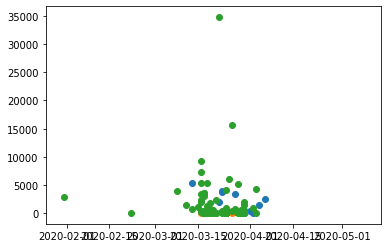

In [156]:
fig, ax = plt.subplots()
figsize=(20,8)

ax.scatter(df["Lockdown", "Full lockdown"], df["target"])

ax.scatter(df["Lockdown", "Lockdown of refugee/idp camps or other minorities"], df["target"])

ax.scatter(df["Lockdown", "Partial lockdown"], df["target"])

plt.show();

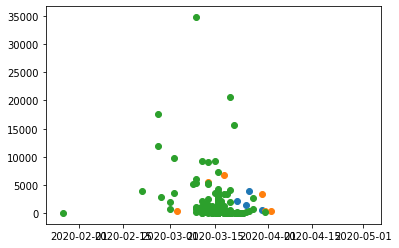

In [157]:
fig, ax = plt.subplots()
figsize=(15,8)

ax.scatter(df['Social distancing', 'limit public gatherings'], df["target"])

ax.scatter(df['Public health measures', 'Mass population testing'], df["target"])

ax.scatter(df["Social distancing", "Schools closure"], df["target"])

plt.show();

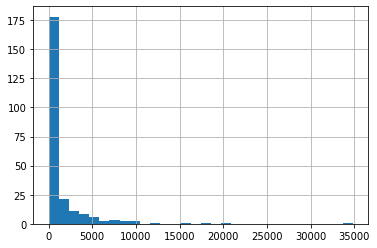

In [158]:
df.target.hist(bins=30)

### Make a copy of the original dataframe

In [159]:
df.set_index("Country/Region", inplace=True)
df = df.drop(["confirmed_cases_on_7/6/2020", "Population"], axis=1)
df_tmp = df.copy()
df.head()

,"(Governance and socio-economic measures, Economic measures)","(Governance and socio-economic measures, Emergency administrative structures activated or established)","(Governance and socio-economic measures, Limit product imports/exports)","(Governance and socio-economic measures, Military deployment)","(Governance and socio-economic measures, State of emergency declared)","(Humanitarian exemption, Humanitarian exemptions)","(Lockdown, Full lockdown)","(Lockdown, Lockdown of refugee/idp camps or other minorities)","(Lockdown, Partial lockdown)","(Movement restrictions, Additional health/documents requirements upon arrival)",...,"(Public health measures, Strengthening the public health system)","(Public health measures, Testing policy)","(Public health measures, strengthening the public health system)","(Public health measures, testing policy)","(Social distancing, Changes in prison-related policies)","(Social distancing, Limit public gatherings)","(Social distancing, Public services closure)","(Social distancing, Schools closure)","(Social distancing, limit public gatherings)",target
Country/Region,,,,,,,,,,,,,,,,,,,,,
Afghanistan,NaT,2020-02-12,2020-03-01,NaT,NaT,NaT,NaT,NaT,NaT,NaT,...,2020-03-01,NaT,NaT,NaT,NaT,2020-03-12,NaT,2020-03-01,NaT,852.592093
Albania,2020-03-12,2020-03-22,NaT,NaT,NaT,NaT,NaT,NaT,2020-04-02,NaT,...,2020-03-19,NaT,NaT,NaT,NaT,2020-03-10,NaT,2020-03-10,NaT,1029.954510
Algeria,NaT,NaT,NaT,2020-03-23,NaT,NaT,NaT,NaT,2020-03-23,NaT,...,NaT,NaT,NaT,NaT,NaT,2020-03-12,2020-03-20,2020-03-12,NaT,374.084594
Angola,2020-03-27,2020-04-06,2020-03-27,NaT,2020-03-27,NaT,NaT,2020-03-26,NaT,NaT,...,2020-03-27,NaT,NaT,NaT,2020-04-02,2020-04-04,2020-03-27,2020-03-23,NaT,10.527510
Antigua and Barbuda,2020-03-16,2020-03-16,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,...,NaT,NaT,NaT,NaT,NaT,2020-03-16,NaT,2020-03-15,NaT,714.803582


## Modelling

### Define transformers

In [160]:
# custom transformer that calculates numbers of days from sixth July
from sklearn.base import BaseEstimator, TransformerMixin

class CustomDateTransformer( BaseEstimator, TransformerMixin ):
    def __init__(self):
        return None
        
    def fit(self, X, y = None):
        return self
    
    
    def transform(self, X, y=None):
        d0 = pd.to_datetime('2020-07-06')
        transformed_X = pd.DataFrame(X.copy())

        # values are scaled to lie between 0 (measure implemented on the date on which COVID-19 cases are reported)
        # and 1 (measure implemented on January first)
        
        transformed_X = (d0 - transformed_X) / (d0-pd.to_datetime('2020-01-01'))
        #transformed_X = transformed_X.astype('timedelta64[D]')

        return transformed_X

In [161]:
d0 = pd.to_datetime('2020-07-06')
(d0 - pd.to_datetime('NaT')) / (d0-pd.to_datetime('2020-01-01'))

nan

### fit a RandomForestRegressor

In [162]:
from sklearn.model_selection import train_test_split, cross_val_score

X = df_tmp.drop("target", axis=1)
y = df_tmp["target"]

random_state = 7
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                   y, 
                                                   test_size=0.1)

In [181]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

date_features = list(X.columns)
date_transformer = Pipeline(steps=[
    ("custom_transformer", CustomDateTransformer()), 
    ("imputer", SimpleImputer(strategy="constant", missing_values=np.nan, fill_value=0))])


In [164]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
        transformers=[
            ("date", date_transformer, date_features)
        ])

In [165]:
from sklearn.ensemble import RandomForestRegressor

model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("randomforest", RandomForestRegressor(n_jobs=-1, 
                             random_state = 7))])

model.fit(X_train, y_train)

    
model.score(X_test, y_test)


0.13665448332450103

In [166]:
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score

def rmsle(y_test, y_preds):
    """
    calculates root mean squared log error between predictions and true labels
    """
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

def show_scores(model):
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    scores = {"Training MAE:": mean_absolute_error(y_train, train_preds), 
              "Validation MAE": mean_absolute_error(y_test, test_preds),
              "Training RMSLE": rmsle(y_train, train_preds), 
              "Validation RMSLE": rmsle(y_test, test_preds), 
              "Training R^2": r2_score(y_train, train_preds), 
              "Validation R^2": r2_score(y_test, test_preds)
             }
    
    return scores

In [167]:
show_scores(model)

{'Training MAE:': 731.8519840434634,
 'Validation MAE': 823.916305043227,
 'Training RMSLE': 2.2089910482145596,
 'Validation RMSLE': 2.365017826254572,
 'Training R^2': 0.825335438342563,
 'Validation R^2': 0.13665448332450092}

In [168]:
print("maximum target value is", max(y), "; minimum target value is", min(y))

maximum target value is 34829.279433595984 ; minimum target value is 0.0


### Hyperparameter tuning using RandomizedSearchCV

In [172]:
from sklearn.model_selection import RandomizedSearchCV

rf_grid = {"n_estimators": np.arange(10,100,10), 
          "max_depth": [None, 3,5,10], 
          "min_samples_split": np.arange(2,20,2), 
          "min_samples_leaf": np.arange(1,20,2), 
          "max_features": [0.5, 1, "sqrt", "auto"]
          }

rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1, 
                                                   random_state=7), 
                             param_distributions=rf_grid, 
                             n_iter=35, 
                             cv=5, 
                             verbose=True)

#X_train = preprocessor.fit_transform(X_train)

rs_model.fit(X_train, y_train)


Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:   31.7s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100, n_jobs=-1,
                   

In [170]:
# find best model hyperparameters
rs_model.best_params_

{'n_estimators': 90,
 'min_samples_split': 12,
 'min_samples_leaf': 3,
 'max_features': 1,
 'max_depth': None}

In [173]:
show_scores(rs_model)

{'Training MAE:': 1843.7696016511761,
 'Validation MAE': 1304.0540707404828,
 'Training RMSLE': 3.8773855457508293,
 'Validation RMSLE': 3.815054999071596,
 'Training R^2': 0.06147939514727574,
 'Validation R^2': -0.14122498299418185}

It seems that the model is performing poorly. Therefore, we shall drop the information about the time when a measure has been implemented and only keep whether it has been implemented or not. 

In [175]:
df_tmp.head()

,"(Governance and socio-economic measures, Economic measures)","(Governance and socio-economic measures, Emergency administrative structures activated or established)","(Governance and socio-economic measures, Limit product imports/exports)","(Governance and socio-economic measures, Military deployment)","(Governance and socio-economic measures, State of emergency declared)","(Humanitarian exemption, Humanitarian exemptions)","(Lockdown, Full lockdown)","(Lockdown, Lockdown of refugee/idp camps or other minorities)","(Lockdown, Partial lockdown)","(Movement restrictions, Additional health/documents requirements upon arrival)",...,"(Public health measures, Strengthening the public health system)","(Public health measures, Testing policy)","(Public health measures, strengthening the public health system)","(Public health measures, testing policy)","(Social distancing, Changes in prison-related policies)","(Social distancing, Limit public gatherings)","(Social distancing, Public services closure)","(Social distancing, Schools closure)","(Social distancing, limit public gatherings)",target
Country/Region,,,,,,,,,,,,,,,,,,,,,
Afghanistan,NaT,2020-02-12,2020-03-01,NaT,NaT,NaT,NaT,NaT,NaT,NaT,...,2020-03-01,NaT,NaT,NaT,NaT,2020-03-12,NaT,2020-03-01,NaT,852.592093
Albania,2020-03-12,2020-03-22,NaT,NaT,NaT,NaT,NaT,NaT,2020-04-02,NaT,...,2020-03-19,NaT,NaT,NaT,NaT,2020-03-10,NaT,2020-03-10,NaT,1029.954510
Algeria,NaT,NaT,NaT,2020-03-23,NaT,NaT,NaT,NaT,2020-03-23,NaT,...,NaT,NaT,NaT,NaT,NaT,2020-03-12,2020-03-20,2020-03-12,NaT,374.084594
Angola,2020-03-27,2020-04-06,2020-03-27,NaT,2020-03-27,NaT,NaT,2020-03-26,NaT,NaT,...,2020-03-27,NaT,NaT,NaT,2020-04-02,2020-04-04,2020-03-27,2020-03-23,NaT,10.527510
Antigua and Barbuda,2020-03-16,2020-03-16,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,...,NaT,NaT,NaT,NaT,NaT,2020-03-16,NaT,2020-03-15,NaT,714.803582


In [239]:
# custom transformer that calculates numbers of days from sixth July
from sklearn.base import BaseEstimator, TransformerMixin

class CustomDateTransformer( BaseEstimator, TransformerMixin ):
    def __init__(self):
        return None
        
    def fit(self, X, y = None):
        return self
    
    
    def transform(self, X, y=None):

        # values are either 1 (measure implemented) or 0 (measure not implemented)
        transformed_X = X.copy()
        transformed_X = np.isnat(X).astype(int)
        #transformed_X = transformed_X.astype('timedelta64[D]')

        return transformed_X

In [236]:
date_features = list(X.columns)
date_transformer = Pipeline(steps=[
    ("custom_transformer", CustomDateTransformer()), 
    ("imputer", SimpleImputer(strategy="constant", missing_values=np.nan, fill_value=0))])


In [237]:
preprocessor = ColumnTransformer(
        transformers=[
            ("date", date_transformer, date_features)
        ])

In [219]:
X

,"(Governance and socio-economic measures, Economic measures)","(Governance and socio-economic measures, Emergency administrative structures activated or established)","(Governance and socio-economic measures, Limit product imports/exports)","(Governance and socio-economic measures, Military deployment)","(Governance and socio-economic measures, State of emergency declared)","(Humanitarian exemption, Humanitarian exemptions)","(Lockdown, Full lockdown)","(Lockdown, Lockdown of refugee/idp camps or other minorities)","(Lockdown, Partial lockdown)","(Movement restrictions, Additional health/documents requirements upon arrival)",...,"(Public health measures, Requirement to wear protective gear in public)","(Public health measures, Strengthening the public health system)","(Public health measures, Testing policy)","(Public health measures, strengthening the public health system)","(Public health measures, testing policy)","(Social distancing, Changes in prison-related policies)","(Social distancing, Limit public gatherings)","(Social distancing, Public services closure)","(Social distancing, Schools closure)","(Social distancing, limit public gatherings)"
Country/Region,,,,,,,,,,,,,,,,,,,,,
Afghanistan,NaT,2020-02-12,2020-03-01,NaT,NaT,NaT,NaT,NaT,NaT,NaT,...,NaT,2020-03-01,NaT,NaT,NaT,NaT,2020-03-12,NaT,2020-03-01,NaT
Albania,2020-03-12,2020-03-22,NaT,NaT,NaT,NaT,NaT,NaT,2020-04-02,NaT,...,NaT,2020-03-19,NaT,NaT,NaT,NaT,2020-03-10,NaT,2020-03-10,NaT
Algeria,NaT,NaT,NaT,2020-03-23,NaT,NaT,NaT,NaT,2020-03-23,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,2020-03-12,2020-03-20,2020-03-12,NaT
Angola,2020-03-27,2020-04-06,2020-03-27,NaT,2020-03-27,NaT,NaT,2020-03-26,NaT,NaT,...,NaT,2020-03-27,NaT,NaT,NaT,2020-04-02,2020-04-04,2020-03-27,2020-03-23,NaT
Antigua and Barbuda,2020-03-16,2020-03-16,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,2020-03-16,NaT,2020-03-15,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Uzbekistan,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
Venezuela,2020-03-17,2020-03-31,NaT,NaT,2020-03-17,NaT,NaT,NaT,2020-03-16,NaT,...,NaT,2020-03-17,NaT,NaT,NaT,NaT,2020-03-15,2020-03-15,2020-03-15,NaT
Yemen,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,...,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT


In [238]:
preprocessor.fit_transform(X)

array([[1, 0, 0, ..., 1, 0, 1],
       [0, 0, 1, ..., 1, 0, 1],
       [1, 1, 1, ..., 0, 0, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 0, 1, ..., 0, 0, 1],
       [1, 1, 1, ..., 0, 0, 1]])

In [241]:
random_state = 7
X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                   test_size=0.2)

In [242]:
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("randomforest", RandomForestRegressor(n_jobs=-1, 
                             random_state = 7))])

model.fit(X_train, y_train)

    
model.score(X_test, y_test)

-0.1551364055096176

### Tuning hyperparameters for the new model using RandomSearchCV

In [244]:
rf_grid = {"n_estimators": np.arange(10,100,10), 
          "max_depth": [None, 3,5,10], 
          "min_samples_split": np.arange(2,20,2), 
          "min_samples_leaf": np.arange(1,20,2), 
          "max_features": [0.5, 1, "sqrt", "auto"]
          }

rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1, 
                                                   random_state=7), 
                             param_distributions=rf_grid, 
                             n_iter=35, 
                             cv=5, 
                             verbose=True)

rs_model.fit(preprocessor.fit_transform(X_train), y_train)

Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 175 out of 175 | elapsed:   31.1s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100, n_jobs=-1,
                   

In [246]:
show_scores(rs_model)

{'Training MAE:': 3299.6068068732397,
 'Validation MAE': 3136.8647723266254,
 'Training RMSLE': 4.618984168028932,
 'Validation RMSLE': 4.761938662856284,
 'Training R^2': -0.4836838205380789,
 'Validation R^2': -1.3772955686974795}